In [6]:
import pandas as pd
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import random

In [7]:
torch.cuda.empty_cache()

In [8]:
#load data
df = pd.read_csv('chembl_for_agents.csv')
smiles_list = df['canonical_smiles'].tolist()

#look at first 5 SMILES
for i in range(5):
    print(smiles_list[i])

NC(=O)C1(NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H](Cc2c[nH]c3ccccc23)NC(=O)[C@@H](Cc2csc3ccccc23)NC(=O)C2CCNCC2)CCNCC1
O=C1CC[C@H](N2C(=O)c3cccc(NCc4ccc(CN5CC(N6CCOCC6)C5)cc4F)c3C2=O)C(=O)N1
CC(C)OC(=O)C(C(=O)OC(C)C)=C1SC=CS1
C[C@H]1CC(=O)C[C@@H]2CC[C@H]3[C@@H]4CC[C@H](O)[C@@]4(C)CC[C@@H]3[C@]21C
COc1c2occc2c(OC)c2c(=O)cc(CSC)oc12


In [9]:
#build a vocabulary
all_chars = sorted(list(set(''.join(smiles_list)))) #get unique characters
all_chars = ['<PAD>'] + ['<SOS>'] + ['<EOS>'] + all_chars #add padding ,sos and eos character
char2idx = {c:i+1 for i, c in enumerate(all_chars)} #dictionary storing char to index mapping

In [10]:
special_tokens = ["<PAD>", "<SOS>", "<EOS>"]
char_list = sorted([c for c in char2idx.keys() if c not in special_tokens])

# Build new mapping starts from 0
char2idx_fixed = { "<PAD>":0, "<SOS>":1, "<EOS>":2 }
for i, c in enumerate(char_list):
    char2idx_fixed[c] = i + 3

idx2char_fixed = {v:k for k,v in char2idx_fixed.items()}

vocab_size = len(char2idx_fixed)  # this is now correct
print(f'Fixed Vocab size: {vocab_size}')
char2idx_fixed

Fixed Vocab size: 56


{'<PAD>': 0,
 '<SOS>': 1,
 '<EOS>': 2,
 '#': 3,
 '%': 4,
 '(': 5,
 ')': 6,
 '+': 7,
 '-': 8,
 '.': 9,
 '/': 10,
 '0': 11,
 '1': 12,
 '2': 13,
 '3': 14,
 '4': 15,
 '5': 16,
 '6': 17,
 '7': 18,
 '8': 19,
 '9': 20,
 '=': 21,
 '@': 22,
 'A': 23,
 'B': 24,
 'C': 25,
 'F': 26,
 'G': 27,
 'H': 28,
 'I': 29,
 'K': 30,
 'L': 31,
 'M': 32,
 'N': 33,
 'O': 34,
 'P': 35,
 'R': 36,
 'S': 37,
 'T': 38,
 'X': 39,
 'Y': 40,
 'Z': 41,
 '[': 42,
 '\\': 43,
 ']': 44,
 'a': 45,
 'b': 46,
 'c': 47,
 'e': 48,
 'g': 49,
 'i': 50,
 'l': 51,
 'n': 52,
 'o': 53,
 'r': 54,
 's': 55}

In [11]:
#find max seq length
max_len = max([len(s) for s in smiles_list])
print(max_len)
[len(s) for s in smiles_list]


1486


[111,
 71,
 34,
 71,
 34,
 39,
 236,
 25,
 49,
 53,
 37,
 42,
 26,
 35,
 27,
 87,
 50,
 80,
 72,
 49,
 215,
 19,
 103,
 53,
 37,
 40,
 31,
 58,
 31,
 49,
 45,
 33,
 64,
 206,
 65,
 43,
 85,
 33,
 47,
 61,
 69,
 30,
 53,
 28,
 63,
 97,
 23,
 32,
 48,
 46,
 39,
 62,
 50,
 80,
 38,
 37,
 32,
 27,
 74,
 54,
 45,
 57,
 133,
 62,
 52,
 104,
 19,
 71,
 23,
 48,
 51,
 56,
 65,
 42,
 27,
 75,
 43,
 60,
 32,
 46,
 46,
 41,
 34,
 16,
 54,
 68,
 67,
 76,
 27,
 71,
 58,
 31,
 197,
 64,
 9,
 44,
 40,
 39,
 167,
 39,
 55,
 26,
 83,
 47,
 52,
 76,
 58,
 116,
 139,
 37,
 41,
 50,
 70,
 55,
 43,
 58,
 36,
 17,
 30,
 51,
 49,
 23,
 55,
 158,
 133,
 44,
 32,
 72,
 58,
 68,
 77,
 60,
 64,
 47,
 77,
 50,
 68,
 38,
 38,
 36,
 74,
 59,
 41,
 30,
 62,
 30,
 125,
 52,
 62,
 23,
 80,
 34,
 107,
 55,
 62,
 32,
 21,
 92,
 31,
 51,
 82,
 125,
 32,
 73,
 51,
 58,
 42,
 34,
 33,
 34,
 40,
 58,
 76,
 80,
 63,
 75,
 84,
 25,
 62,
 69,
 58,
 44,
 39,
 98,
 13,
 52,
 96,
 29,
 45,
 16,
 36,
 32,
 33,
 57,
 64,
 83,
 43,


In [12]:
def encode_smiles(smiles, char2idx, max_len):

    #add sos and eos tokens
    tokens = ['<SOS>'] + list(smiles) + ['<EOS>']
    token_ids = [char2idx[t] for t in tokens]  # fallback to <sos> if unknown

    #padding
    if len(token_ids) < max_len:
        token_ids += [char2idx['<PAD>']]*(max_len - len(token_ids)) 

    else:
        token_ids = token_ids[:max_len] #truncation

    return token_ids


In [13]:
class MoleculeDataset(Dataset):
    def __init__(self, smiles_list, char2idx, max_len):
        self.smiles = smiles_list
        self.max_len = max_len
        self.char2idx = char2idx

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        encoded = encode_smiles(self.smiles[idx], self.char2idx, self.max_len)
        return torch.tensor(encoded, dtype=torch.long)

In [14]:
#collate function for decoder input and target

def collate_fn(batch):

    batch = torch.stack(batch, dim=0)  # (batch_size, seq_len)

    #decoder input is all but last token eos
    decoder_input = batch[:, :-1] #with sos

    #target is all but first token sos
    target = batch[:, 1:] #with eos

    return decoder_input, target

In [15]:
#create dataset and dataloader
dataset = MoleculeDataset(smiles_list, char2idx_fixed, max_len=max_len)  
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
dataset[0]

tensor([ 1, 33, 25,  ...,  0,  0,  0])

In [16]:
#checking
max_idx = max(char2idx_fixed.values())
print("Vocab size:", vocab_size)
print("Max index used:", max_idx)
assert vocab_size > max_idx, "vocab_size must be larger than largest index!"

Vocab size: 56
Max index used: 55


In [17]:
for s in smiles_list[:10]:
    encoded = encode_smiles(s, char2idx_fixed, max_len)
    assert max(encoded) < vocab_size, f"Found index {max(encoded)} >= vocab_size"

In [18]:
#defining a LSTM(RNN) VAE model

### MODEL ARCHITECTURE ###
class SMILEVAE(nn.Module):
    def __init__(self, vocab_size, embed_size=64, hidden_size=128, latent_size=64, max_len=120):
        super (SMILEVAE, self).__init__()

        #create embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=char2idx_fixed['<PAD>']) 

        #encoder layers
        self.encoder_lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.hidden2mean = nn.Linear(hidden_size, latent_size)
        self.hidden2logvar = nn.Linear(hidden_size, latent_size)

        #decoder layers
        self.latent2hidden = nn.Linear(latent_size, hidden_size)
        self.decoder_lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)

        #output layer
        self.outputs2vocab = nn.Linear(hidden_size, vocab_size)

    
    def encode(self, x):
        x = self.embed(x)
        _, (h, _) = self.encoder_lstm(x) #only take final hidden state
        h = h[-1] #last layer only
        mean = self.hidden2mean(h)
        logvar = self.hidden2logvar(h)
        
        return mean, logvar
    
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)

        return mean + eps*std
    

    def decode(self, z, x=None):
        h = self.latent2hidden(z).unsqueeze(0) #z:(batch, latent_size)
        c = torch.zeros_like(h) #initial cell state
        batch_size = z.size(0)

        #input token
        if x is None: #inference mode
            x_in = torch.zeros(batch_size, self.max_len, dtype=torch.long, device=z.device)#start with all padding tokens
            
        else: #training mode
            x_in = x

        x_emb = self.embed(x_in)
        out, _ = self.decoder_lstm(x_emb, (h, c))
        logits = self.outputs2vocab(out)

        return logits
    

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        logits = self.decode(z, x)

        return logits, mean, logvar

In [19]:
#training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SMILEVAE(vocab_size=vocab_size, embed_size=64, hidden_size=128, latent_size=64, max_len=max_len).to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-3)

In [20]:
#loss funtion
def vae_loss( logits, target, mean, logvar):
    
    #flatten logits and target for cross-entropy loss
    logits_flat = logits.reshape(-1, logits.size(-1))  # (batch_size*seq_len, vocab_size)
    target_flat = target.reshape(-1)  # (batch_size*seq_len)

    #Reconstruction Loss
    recon_loss = F.cross_entropy(logits_flat, target_flat, ignore_index=char2idx_fixed['<PAD>'])

    #KL Divergence Loss
    kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())

    return recon_loss + kl_loss, recon_loss, kl_loss
    
    

In [21]:
#testing
batch_size = 4  # dummy small batch
dummy_input = torch.randint(1, vocab_size, (batch_size, max_len)).to(device)

model.eval()
with torch.no_grad():
    logits, mean, logvar = model(dummy_input)

print("Input Shape:", dummy_input.shape)
print("Output logits:", logits.shape)
print("Latent Mean:", mean.shape)
print("Latent LogVar:", logvar.shape)

Input Shape: torch.Size([4, 1486])
Output logits: torch.Size([4, 1486, 56])
Latent Mean: torch.Size([4, 64])
Latent LogVar: torch.Size([4, 64])


In [22]:
for decoder_input, target in dataloader:

    print(decoder_input.shape, target.shape)
    break

torch.Size([64, 1485]) torch.Size([64, 1485])


In [23]:
####  WARNING: TRAINING LOOP EXECUTION ####

#training loop

#record
loss_arr = []
recon_arr = []
kl_arr = []

epochs = 20

model.train()
print("Current device:", device)

for epoch in range(1, epochs+1):
    total_loss = 0
    total_recon = 0
    total_kl = 0

    for decoder_input, target in dataloader:

        decoder_input = decoder_input.to(device)
        target = target.to(device)

        optimiser.zero_grad()
        logits, mean, logvar = model(decoder_input)

        loss, recon_loss, kl_loss = vae_loss(logits, target, mean, logvar)
        loss.backward()
        optimiser.step()

        total_loss += loss.item() * decoder_input.size(0)
        total_recon += recon_loss.item() * decoder_input.size(0)
        total_kl += kl_loss.item() * decoder_input.size(0)

    avg_loss = total_loss / len(dataloader.dataset)
    avg_recon = total_recon / len(dataloader.dataset)   
    avg_kl = total_kl / len(dataloader.dataset)

    #append to array
    loss_arr.append(avg_loss)
    recon_arr.append(avg_recon)
    kl_arr.append(avg_kl)

    print(f'Epoch {epoch}, Loss: {avg_loss:.4f}, Recon Loss: {avg_recon:.4f}, KL Loss: {avg_kl:.4f}')


Current device: cuda
Epoch 1, Loss: 1.8595, Recon Loss: 1.8574, KL Loss: 0.0021
Epoch 2, Loss: 1.2271, Recon Loss: 1.2270, KL Loss: 0.0000
Epoch 3, Loss: 1.1032, Recon Loss: 1.1032, KL Loss: 0.0000
Epoch 4, Loss: 1.0287, Recon Loss: 1.0287, KL Loss: 0.0000
Epoch 5, Loss: 0.9786, Recon Loss: 0.9786, KL Loss: 0.0000
Epoch 6, Loss: 0.9442, Recon Loss: 0.9442, KL Loss: 0.0000
Epoch 7, Loss: 0.9159, Recon Loss: 0.9159, KL Loss: 0.0000
Epoch 8, Loss: 0.8933, Recon Loss: 0.8933, KL Loss: 0.0000
Epoch 9, Loss: 0.8730, Recon Loss: 0.8730, KL Loss: 0.0000
Epoch 10, Loss: 0.8562, Recon Loss: 0.8562, KL Loss: 0.0000
Epoch 11, Loss: 0.8399, Recon Loss: 0.8399, KL Loss: 0.0000
Epoch 12, Loss: 0.8272, Recon Loss: 0.8272, KL Loss: 0.0000
Epoch 13, Loss: 0.8184, Recon Loss: 0.8184, KL Loss: 0.0000
Epoch 14, Loss: 0.8020, Recon Loss: 0.8020, KL Loss: 0.0000
Epoch 15, Loss: 0.7921, Recon Loss: 0.7921, KL Loss: 0.0000
Epoch 16, Loss: 0.7826, Recon Loss: 0.7826, KL Loss: 0.0000
Epoch 17, Loss: 0.7756, Reco

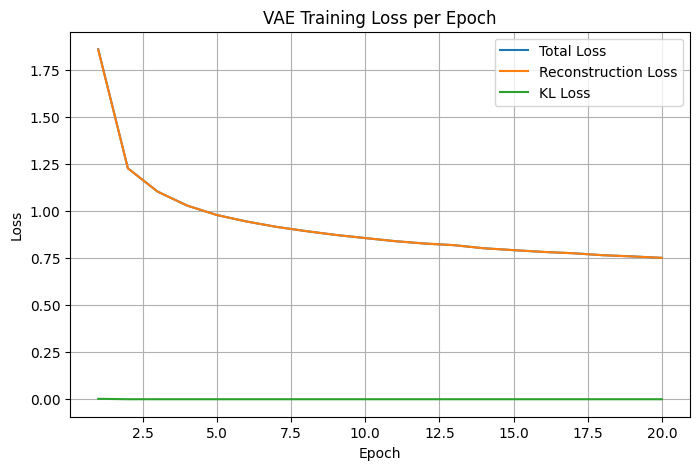

In [24]:
#plot loss curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), loss_arr, label='Total Loss')
plt.plot(range(1, epochs+1), recon_arr, label='Reconstruction Loss')
plt.plot(range(1, epochs+1), kl_arr, label='KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
#function to make sure all prediction have balanced () [] and are about the length of the original

def clean_reconstructed_smiles(smiles, original_len, max_extra=8):
    max_len = original_len * 2  # absolute hard limit
    target_max_len = original_len + max_extra

    stack_round = 0
    stack_square = 0
    result = []

    for i, char in enumerate(smiles):

        # Track brackets
        if char == '(':
            stack_round += 1
        elif char == ')':
            if stack_round > 0:
                stack_round -= 1
            else:
                continue

        if char == '[':
            stack_square += 1
        elif char == ']':
            if stack_square > 0:
                stack_square -= 1
            else:
                continue

        result.append(char)

        #hard stop if too long
        if len(result) >= original_len * 2:
            break
         
        # Stop if roughly near the target length and all stacks are balanced
        if len(result) >= target_max_len and stack_round == 0 and stack_square == 0:
            break

    #auto close remaining brackets
    result.extend(')' * stack_round)
    result.extend(']' * stack_square) 

    return ''.join(result)

In [51]:
#test reconstruction
#reconstruction function
def reconstruct_smiles(model, dataset, num_samples=5):
    model.eval()

    with torch.no_grad():
        for i in range(5):  # first 5 samples
            sample = dataset[i]  # one sample tensor
            sample = sample.unsqueeze(0).to(device)  # add batch dim → (1, seq_len)

            logits, mean, logvar = model(sample)
            pred_tokens = logits.argmax(dim=-1).squeeze(0).tolist()  # (seq_len)

            # Convert original and prediction back to string and removing sos eos pad
            original = ''.join([idx2char_fixed[idx] for idx in sample.squeeze(0).tolist() if idx not in [char2idx_fixed['<PAD>'],char2idx_fixed['<SOS>'], char2idx_fixed['<EOS>']]])
            reconstructed = ''.join([idx2char_fixed[idx] for idx in pred_tokens if idx not in [char2idx_fixed['<PAD>'], char2idx_fixed['<SOS>'], char2idx_fixed['<EOS>']]])

            #use helper function to cleanup
            reconstructed = clean_reconstructed_smiles(reconstructed, len(original))

            print(f"Sample {i+1}")
            print(f"Original:      {original}")
            print(f"Reconstructed: {reconstructed}")


In [52]:
reconstruct_smiles(model, dataset)

Sample 1
Original:      NC(=O)C1(NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H](Cc2c[nH]c3ccccc23)NC(=O)[C@@H](Cc2csc3ccccc23)NC(=O)C2CCNCC2)CCNCC1
Reconstructed: Cc(=O)c1CcC(=O)CC@H(Cc2ccccc2)NC(=O)[C@HH](NC2ccnHc3ccccc23)NC(=O)[C@HH](NC2ccc(ccccc2))NC(=O)[CCC((2)CC1111)]
Sample 2
Original:      O=C1CC[C@H](N2C(=O)c3cccc(NCc4ccc(CN5CC(N6CCOCC6)C5)cc4F)c3C2=O)C(=O)N1
Reconstructed: C=C(CCCC@H(NCCC=O)C3ccc(cCC(3ccccCl4CCNC)CCCCC5)CC)cc3C3cOCC=ON1=====
Sample 3
Original:      CC(C)OC(=O)C(C(=O)OC(C)C)=C1SC=CS1
Reconstructed: CC(C)(C(=O)[(C)=O)OCC()cC(CCCC12cCCC====[[[[[[[CC22222c)]]]]]]]]
Sample 4
Original:      C[C@H]1CC(=O)C[C@@H]2CC[C@H]3[C@@H]4CC[C@H](O)[C@@]4(C)CC[C@@H]3[C@]21C
Reconstructed: CCC@@1C[[=ON2C@@H]1[[[C@H]3[C@@H]4CCCC@@](C)CC@HH((C)CC[C@@H]4[C@@2(C))]]]
Sample 5
Original:      COc1c2occc2c(OC)c2c(=O)cc(CSC)oc12
Reconstructed: CCc1cccc(ccc(=C)c(c(OO)c((C(()cc22C)))))
